# Presentation plots
***

**Author**: Chus Casado<br>
**Date**: 27-02-2023<br>

**Introduction**:<br>


**Questions**:<br>


**Tasks to do**:<br>

**Interesting links**<br>
[Pythonic way to perform statistics across multiple variables with Xarray](https://towardsdatascience.com/pythonic-way-to-perform-statistics-across-multiple-variables-with-xarray-d0221c78e34a)

In [1]:
import os
path_root = os.getcwd()
import glob
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
import time

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

os.chdir('../py/')
from computations import *
from plots import *
os.chdir(path_root)

In [2]:
stn = 350

### 1 Discharge forecast

#### List available data

In [3]:
path_forecast = 'E:/casadje/Documents/skill_assessment/data/CDS/forecast/'

# models = ['COS', 'DWD', 'EUD', 'EUE']

# list files
fore_files = {model: [] for model in models}
for year in [2020, 2021, 2022]:
    for month in range(1, 13):    
        # list files
        for model in models:
            fore_files[model] += glob.glob(f'{path_forecast}{model}/{year}/{month:02d}/*.nc')

# count files and check if all are avaible
n_files = pd.Series(data=[len(fore_files[model]) for model in models], index=models)

# list of forecast from the beginning to the end of the data
start, end = datetime(2021, 6, 20), datetime(2021, 8, 1)
for model in models:
    st, en = [datetime.strptime(fore_files[model][step][-13:-3], '%Y%m%d%H') for step in [0, -1]]
    start = max(st, start)
    end = min(en, end)
dates = pd.date_range(start, end, freq='12h')

# find missing files
if any(n_files != len(dates)):
    missing = {}
    for model in models:
        filedates = [datetime.strptime(file[-13:-3], '%Y%m%d%H') for file in fore_files[model]]    
        missing[model] = [date for date in dates if date not in filedates]
    print('mising files:', missing)

# trim files to the period where all models are available
for model in models:
    fore_files[model] = [file for file in fore_files[model] if start <= datetime.strptime(file[-13:-3], '%Y%m%d%H') <= end]
    print('{0}:\t{1} files'.format(model, len(fore_files[model])))

mising files: {'COS': [], 'DWD': [], 'EUD': [], 'EUE': []}
COS:	85 files
DWD:	85 files
EUD:	85 files
EUE:	85 files


## 2 Analysis

### 2.1 Stations 

In [4]:
# load selected points for all the catchments
stations = pd.DataFrame()
catchments = []
results_path = '../results/reporting_points/'
for folder in os.listdir(results_path):
    try:
        stn_cat = pd.read_csv(f'{results_path}{folder}/points_selected.csv', index_col='station_id')
        stations = pd.concat((stations, stn_cat))
        catchments.append(folder)
    except:
        continue
print('no. stations:\t\t\t{0}'.format(stations.shape[0]))

no. stations:			900


In [5]:
stations = pd.DataFrame(stations.loc[stn]).transpose()

### Reanalysis

In [6]:
# load probability of exceeding the discharge threshold in the REANALYSIS data
Qobs = pd.read_parquet(f'../data/discharge/reanalysis/EFAS_discharge_reanalysis.parquet')
Qobs.columns = Qobs.columns.astype(int)
Qobs = Qobs[stn]
Qobs.head()

2020-10-14 18:00:00    142.910156
2020-10-15 00:00:00    140.178711
2020-10-15 06:00:00    137.594727
2020-10-15 12:00:00    135.061523
2020-10-15 18:00:00    132.731445
Name: 350, dtype: float32

### 2.2 Reforecast data: exceedance probability

This section will iteratively (station by station) load all the available forecast and compute the probability of exceeding the discharge threshold for each of the meteorological forcings. The result will be a NetCDF file for each station that contains the exceedance probability. These files will be later used in the skill assessment.

In [7]:
# # export files station by station
# path = f'../data/exceedance/forecast/'
# if os.path.exists(path) is False:
#     os.makedirs(path)

# # select stations that haven't been processed before
# files = glob.glob(f'{path}*.nc')
# if len(files) > 0:
#     old_stations = [int(file.split('\\')[-1].split('.')[0]) for file in files]
#     new_stations = set(stations.index).difference(old_stations)
#     stations = stations.loc[new_stations]
#     print('no. new stations:\t\t\t{0}'.format(stations.shape[0]))

# generate a DataArray with the discharge threshold of the stations in the catchment
thresholds = xr.DataArray(stations.rl5, dims='id', coords={'id': stations.index.astype(str).tolist()})

In [8]:
models

{'COS': {'members': 20, 'leadtimes': 22},
 'DWD': {'members': 1, 'leadtimes': 28},
 'EUD': {'members': 1, 'leadtimes': 40},
 'EUE': {'members': 51, 'leadtimes': 40}}

In [9]:
thresholds = stations.loc[350, ['rl1.5', 'rl2', 'rl5', 'rl20']]

In [25]:
dis = xr.open_dataarray(file)
dis

<xarray.DataArray 'dis' (member: 20, time: 23, stations: 2371)>
[1090660 values with dtype=float32]
Coordinates:
  * stations  (stations) object '1077' '1019' '2592' ... '1688' '1690' '2274'
  * time      (time) datetime64[ns] 2021-07-12T06:00:00 ... 2021-07-17T18:00:00
Dimensions without coordinates: member

COS	E:/casadje/Documents/skill_assessment/data/CDS/forecast/COS/2021/08\COS2021080100.nc


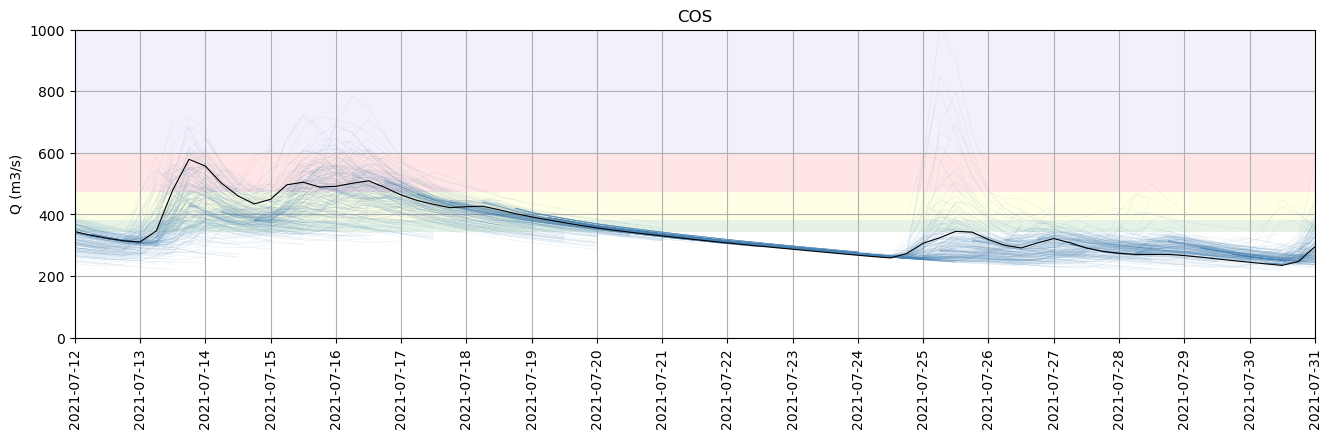

In [17]:
start, end = datetime(2021, 7, 12), datetime(2021, 7, 31)

for model in models:

    fig, ax = plt.subplots(figsize=(16, 4))

    for file in fore_files[model]:

        print(f'{model}\t{file}', end='\r')

        # open dataaray with dicharge data
        dis = xr.open_dataarray(file).isel(time=slice(1, None))
        dis['time'] = dis.time - np.timedelta64(6, 'h')
        # limit the forecast to its maximum leadtime
        if len(dis.time) > models[model]['leadtimes']:
            dis = dis.isel(time=slice(None, models[model]['leadtimes']))

        dis_stn = dis.sel(stations=str(stn))

        if 'member' in dis_stn.dims:
            for member in dis_stn.member.data:
                ax.plot(dis_stn.time, dis_stn.sel(member=member), c='steelblue', lw=.33, alpha=.15)
        else:
            ax.plot(dis_stn.time, dis_stn, c='steelblue', lw=.5, alpha=.33)

    ax.plot(Qobs.index, Qobs, c='k', lw=.8, zorder=5)

    ymax = 1000
    ax.set(xlim=(start, end), ylim=(0, ymax), ylabel='Q (m3/s)')
    xticks = pd.date_range(start, end, freq='d').date
    ax.set_xticks(xticks, labels=xticks, rotation=90)
    ax.grid(True)

    if thresholds is not None:
        ax.fill_between(pd.date_range(datetime(2021, 7, 1), datetime(2021, 7, 31)), *thresholds[0:2], color='green', edgecolor=None, alpha=.1, zorder=0, label='1.5-year')
        ax.fill_between(pd.date_range(datetime(2021, 7, 1), datetime(2021, 7, 31)), *thresholds[1:3], color='yellow', edgecolor=None, alpha=.1, zorder=0, label='2-year')
        ax.fill_between(pd.date_range(datetime(2021, 7, 1), datetime(2021, 7, 31)), *thresholds[2:4], color='red', edgecolor=None, alpha=.1, zorder=0, label='5-year')
        ax.fill_between(pd.date_range(datetime(2021, 7, 1), datetime(2021, 7, 31)), thresholds[-1], ymax, color='mediumpurple', edgecolor=None, alpha=.1, zorder=0, label='20-year')

    ax.set_title(model);

    # plt.savefig(f'../results/skill/explanation/350_{model}.jpg', dpi=300, bbox_inches='tight')
    
    print()
    
    break

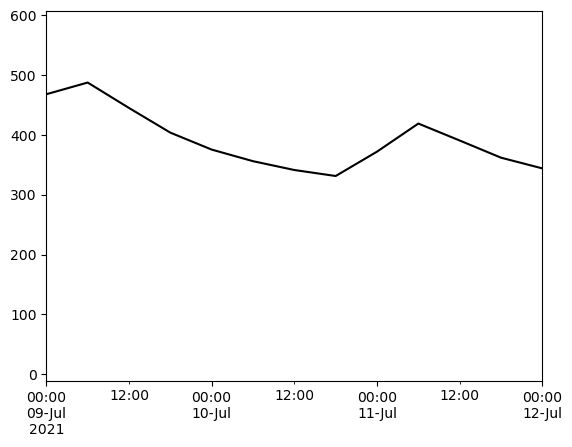

In [18]:
Qobs.plot(color='k')
plt.xlim(datetime(2021, 7, 9), datetime(2021, 7, 12))
plt.ylim=(0, 800)

In [19]:
model = 'DWD'
forecast = '2021071200'
file = [file for file in fore_files['DWD'] if forecast in file][0]
dwd = xr.open_dataarray(file).sel(stations='350').isel(time=slice(1, None))
dwd['time'] = dwd.time - np.timedelta64(6, 'h')

In [20]:
model = 'EUD'
file = [file for file in fore_files[model] if forecast in file][0]
eud = xr.open_dataarray(file).sel(stations='350').isel(time=slice(1, None))
eud['time'] = eud.time - np.timedelta64(6, 'h')

In [21]:
model = 'COS'
file = [file for file in fore_files[model] if forecast in file][0]
cos = xr.open_dataarray(file).sel(stations='350').isel(time=slice(1, None))
cos['time'] = cos.time - np.timedelta64(6, 'h')

In [32]:
da = xr.open_dataset('../data/COS_2021071200.nc')
da.time

<xarray.DataArray 'time' ()>
array('2021-07-12T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2021-07-12
    surface  float64 ...
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

In [34]:
da.time

<xarray.DataArray 'time' ()>
array('2021-07-12T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2021-07-12
    surface  float64 0.0
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

In [39]:
xr.open_dataset('E:/casadje/Documents/skill_assessment/data/CDS/forecast/COS/2021/07/COS2021071200.nc')

<xarray.Dataset>
Dimensions:   (member: 20, time: 23, stations: 2371)
Coordinates:
  * stations  (stations) object '1077' '1019' '2592' ... '1688' '1690' '2274'
  * time      (time) datetime64[ns] 2021-07-12T06:00:00 ... 2021-07-17T18:00:00
Dimensions without coordinates: member
Data variables:
    dis       (member, time, stations) float32 ...

In [40]:
da.step + da.time

<xarray.DataArray (step: 29)>
array(['2021-07-12T00:00:00.000000000', '2021-07-12T06:00:00.000000000',
       '2021-07-12T12:00:00.000000000', '2021-07-12T18:00:00.000000000',
       '2021-07-13T00:00:00.000000000', '2021-07-13T06:00:00.000000000',
       '2021-07-13T12:00:00.000000000', '2021-07-13T18:00:00.000000000',
       '2021-07-14T00:00:00.000000000', '2021-07-14T06:00:00.000000000',
       '2021-07-14T12:00:00.000000000', '2021-07-14T18:00:00.000000000',
       '2021-07-15T00:00:00.000000000', '2021-07-15T06:00:00.000000000',
       '2021-07-15T12:00:00.000000000', '2021-07-15T18:00:00.000000000',
       '2021-07-16T00:00:00.000000000', '2021-07-16T06:00:00.000000000',
       '2021-07-16T12:00:00.000000000', '2021-07-16T18:00:00.000000000',
       '2021-07-17T00:00:00.000000000', '2021-07-17T06:00:00.000000000',
       '2021-07-17T12:00:00.000000000', '2021-07-17T18:00:00.000000000',
       '2021-07-18T00:00:00.000000000', '2021-07-18T06:00:00.000000000',
       '2021-07-18T12:00:00.000000000', '2021-07-18T18:00:00.000000000',
       '2021-07-19T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    time        datetime64[ns] 2021-07-12
  * step        (step) timedelta64[ns] 0 days 00:00:00 ... 7 days 00:00:00
    surface     float64 0.0
    valid_time  (step) datetime64[ns] 2021-07-12 ... 2021-07-19

In [35]:
da.step

<xarray.DataArray 'step' (step: 29)>
array([              0,  21600000000000,  43200000000000,  64800000000000,
        86400000000000, 108000000000000, 129600000000000, 151200000000000,
       172800000000000, 194400000000000, 216000000000000, 237600000000000,
       259200000000000, 280800000000000, 302400000000000, 324000000000000,
       345600000000000, 367200000000000, 388800000000000, 410400000000000,
       432000000000000, 453600000000000, 475200000000000, 496800000000000,
       518400000000000, 540000000000000, 561600000000000, 583200000000000,
       604800000000000], dtype='timedelta64[ns]')
Coordinates:
    time        datetime64[ns] 2021-07-12
  * step        (step) timedelta64[ns] 0 days 00:00:00 ... 7 days 00:00:00
    surface     float64 0.0
    valid_time  (step) datetime64[ns] 2021-07-12 ... 2021-07-19
Attributes:
    long_name:      time since forecast_reference_time
    standard_name:  forecast_period

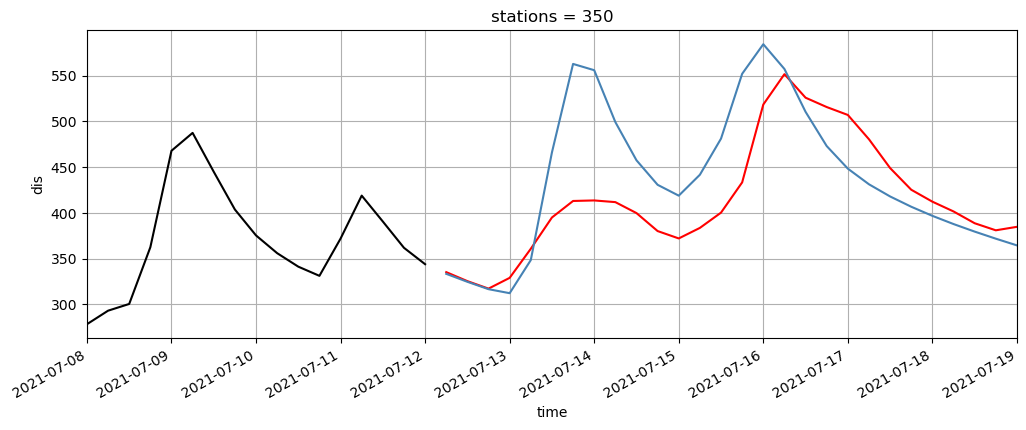

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))
fc = datetime.strptime(forecast, '%Y%m%d%H')
start = datetime.strptime(forecast, '%Y%m%d%H') - timedelta(days=4)
end = pd.to_datetime(dwd.time.max().data)

eud.plot(color='r')
dwd.plot(color='steelblue')
qobs = Qobs[start:fc]
ax.plot(qobs.index, qobs, color='k')
plt.grid(True)
xticks = pd.date_range(start, end, freq='d').date
plt.xticks(ticks=xticks, labels=xticks)
plt.xlim((start, end));
# plt.ylim((0, 800))

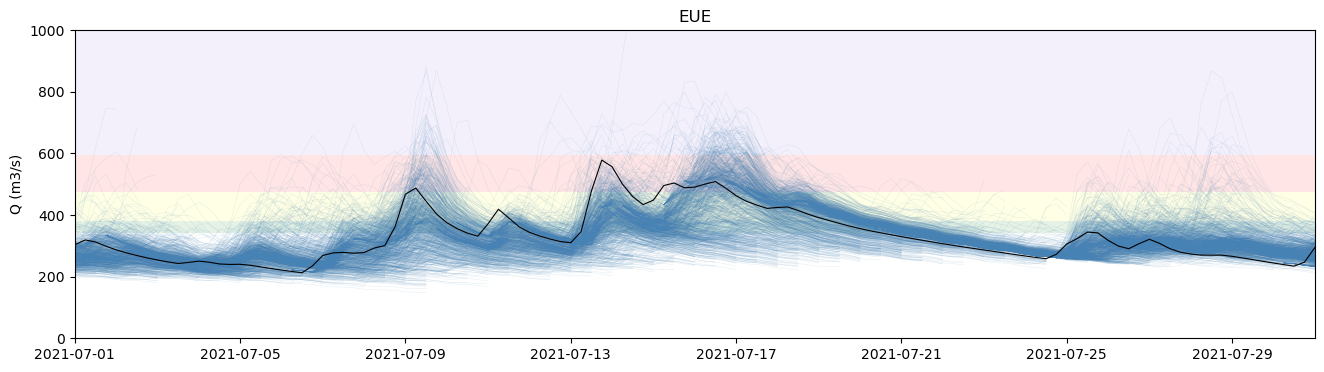

In [11]:
fig, ax = plt.subplots(figsize=(16, 4))
model = 'EUE'
verbose = True


for file in fore_files[model]:
            
    if verbose:
        print(f'{model}\t{file}', end='\r')
        
    # open dataaray with dicharge data
    dis = xr.open_dataarray(file)
    # limit the forecast to 10 days
    if len(dis.time) > models[model]['leadtimes']:
        dis = dis.isel(time=slice(None, models[model]['leadtimes']))

    dis_stn = dis.sel(stations=stations.index.astype(str))

    for member in dis_stn.member.data:
        ax.plot(dis_stn.time, dis_stn.sel(member=member), c='steelblue', lw=.33, alpha=.15)
        
ax.plot(Qobs.index, Qobs, c='k', lw=.8, zorder=5)

ymax = 1000
ax.set(xlim=(datetime(2021, 7, 1), datetime(2021, 7, 31)), ylim=(0, ymax), ylabel='Q (m3/s)')

if thresholds is not None:
    ax.fill_between(pd.date_range(datetime(2021, 7, 1), datetime(2021, 7, 31)), *thresholds[0:2], color='green', edgecolor=None, alpha=.1, zorder=0, label='1.5-year')
    ax.fill_between(pd.date_range(datetime(2021, 7, 1), datetime(2021, 7, 31)), *thresholds[1:3], color='yellow', edgecolor=None, alpha=.1, zorder=0, label='2-year')
    ax.fill_between(pd.date_range(datetime(2021, 7, 1), datetime(2021, 7, 31)), *thresholds[2:4], color='red', edgecolor=None, alpha=.1, zorder=0, label='5-year')
    ax.fill_between(pd.date_range(datetime(2021, 7, 1), datetime(2021, 7, 31)), thresholds[-1], ymax, color='mediumpurple', edgecolor=None, alpha=.1, zorder=0, label='20-year')
    
ax.set_title(model);

# plt.savefig(f'../results/skill/explanation/350_{model}.jpg', dpi=300, bbox_inches='tight')

In [ ]:
exceedance = xr.open_dataarray('E:/casadje/GitHub/EFAS_skill/data/exceedance/forecast/0350.nc')
exceedance = exceedance.sel(forecast=slice(datetime(2021, 6, 20), datetime(2021, 8, 1)))
exceedance = reshape_DataArray(exceedance)
exceedance = exceedance.sel(datetime=slice(datetime(2021, 7, 1), datetime(2021, 7, 31)))
exceedance

In [ ]:
[int(dct['leadtimes'] / 2) for label, dct in models.items()]

In [ ]:
stn = 350

In [ ]:
cmap_p, norm_p = create_cmap('magma_r', np.arange(0, 1.01, .05))

In [ ]:
fig = plt.figure(figsize=(16, 10), constrained_layout=True)
height_ratios = [int(dct['leadtimes'] / 2) for label, dct in models.items()]
gs = fig.add_gridspec(nrows=len(height_ratios), height_ratios=height_ratios)

for i, (label, dct) in enumerate(models.items()):
    ax = fig.add_subplot(gs[i])
    if i + 1 < len(height_ratios):
        xticklabels, xlabel = [], None
    else:
        xticklabels, xlabel = exceedance.datetime.data, 'datetime'
    ylabel = 'leadtime (h)'
    if i == 2:
        cbar = True
    else:
        cbar = False
    plot_DataArray(exceedance.sel(model=label).isel(leadtime=slice(0, int(models[label]['leadtimes'] / 2))),
                   xtick_step=4, ytick_step=2, cbar=cbar, cbar_kws={'label': 'probability'}, title=label, xticklabels=xticklabels, xlabel=xlabel,
                   ylabel=ylabel, ax=ax, cmap=cmap_p, norm=norm_p)
    
fig.suptitle('{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'catchment']]), fontsize=13);

In [ ]:
# exceedance according to mean over models
model_mean = exceedance.mean('model', skipna=True)

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(16, 7), sharex=True, sharey=True, constrained_layout=True)

plot_DataArray(model_mean, xtick_step=4, ytick_step=2, cbar=True, cbar_kws={'label': 'probability'}, title='total probability', xlabel='datetime',
                   ylabel='leadtime (h)', cmap=cmap_p, norm=norm_p, ax=ax[0])

plot_DataArray(model_mean> .3, xtick_step=4, ytick_step=2, cbar=True, cbar_kws={'label': 'probability'}, title='exceedance', xlabel='datetime',
                   ylabel='leadtime (h)', cmap=cmap_p, norm=norm_p, ax=ax[1])

fig.suptitle('{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'catchment']]), fontsize=13);

In [ ]:
# by the number of membes
path_out = '../results/skill/EFAS/eventwise/'
weights_member = xr.open_dataarray(f'{path_out}weights_member.nc')

In [ ]:
# exceedance according to the mean over models weighted by the number of members
member_weighted = exceedance.weighted(weights_member).mean('model', skipna=True)

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(16, 7), sharex=True, sharey=True, constrained_layout=True)

plot_DataArray(member_weighted, xtick_step=4, ytick_step=2, cbar=True, cbar_kws={'label': 'probability'}, title='total probability', xlabel='datetime',
                   ylabel='leadtime (h)', cmap=cmap_p, norm=norm_p, ax=ax[0])

plot_DataArray(member_weighted> .3, xtick_step=4, ytick_step=2, cbar=True, cbar_kws={'label': 'probability'}, title='exceedance', xlabel='datetime',
                   ylabel='leadtime (h)', cmap=cmap_p, norm=norm_p, ax=ax[1])

fig.suptitle('{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'catchment']]), fontsize=13);

In [ ]:
# by the Brier score
weights_brier = xr.open_dataarray(f'{path_out}weights_brier.nc', engine='netcdf4')

# exceedance according to the mean over models weighted by the number of members
brier_weighted = exceedance.weighted(weights_brier.fillna(0)).mean('model', skipna=True)

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(16, 7), sharex=True, sharey=True, constrained_layout=True)

plot_DataArray(brier_weighted, xtick_step=4, ytick_step=2, cbar=True, cbar_kws={'label': 'probability'}, title='total probability', xlabel='datetime',
                   ylabel='leadtime (h)', cmap=cmap_p, norm=norm_p, ax=ax[0])

plot_DataArray(brier_weighted> .3, xtick_step=4, ytick_step=2, cbar=True, cbar_kws={'label': 'probability'}, title='exceedance', xlabel='datetime',
                   ylabel='leadtime (h)', cmap=cmap_p, norm=norm_p, ax=ax[1])

fig.suptitle('{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'catchment']]), fontsize=13);

In [ ]:
exc_o_thr = exceedance >= .3

In [ ]:
cmap_eot, norm_eot = create_cmap('magma_r', np.arange(0, 1.01, .5))

In [ ]:
fig = plt.figure(figsize=(16, 10), constrained_layout=True)
height_ratios = [int(dct['leadtimes'] / 2) for label, dct in models.items()]
gs = fig.add_gridspec(nrows=len(height_ratios), height_ratios=height_ratios)

for i, (label, dct) in enumerate(models.items()):
    ax = fig.add_subplot(gs[i])
    if i + 1 < len(height_ratios):
        xticklabels, xlabel = [], None
    else:
        xticklabels, xlabel = exceedance.datetime.data, 'datetime'
    ylabel = 'leadtime (h)'
    if i == 2:
        cbar = True
    else:
        cbar = False
    plot_DataArray(exc_o_thr.sel(model=label).isel(leadtime=slice(0, int(models[label]['leadtimes'] / 2))),
                   xtick_step=4, ytick_step=2, cbar=cbar, cbar_kws={'label': 'exceedance over threshold'}, title=label, xticklabels=xticklabels, xlabel=xlabel,
                   ylabel=ylabel, ax=ax, cmap=cmap_eot, norm=norm_eot)
    
fig.suptitle('{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'catchment']]), fontsize=13);

In [ ]:
# exceedance according to current criteria
deterministic = (exceedance.sel(model=['EUD', 'DWD']) >= .3).any('model')
probabilistic = (exceedance.sel(model=['EUE', 'COS']) >= .3).any('model')
current = deterministic & probabilistic

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(16, 10), sharex=True, sharey=True, constrained_layout=True)

plot_DataArray(deterministic, ax=ax[0], cmap=cmap_eot, norm=norm_eot, cbar=False, title='deterministic')
plot_DataArray(probabilistic, ax=ax[1], cmap=cmap_eot, norm=norm_eot, cbar=True, cbar_kws={'shrink': .25, 'label': 'exceedance over threshold'}, title='probabilistic')
plot_DataArray(current, ax=ax[2], cmap=cmap_eot, norm=norm_eot, cbar=False, title='deterministic & probabilistic',
               xtick_step=4, ytick_step=2)

fig.suptitle('{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'catchment']]), fontsize=13);

In [ ]:
current

In [ ]:
min_leadtime = 60
persistence = (3, 3)

***

In [ ]:
def compute_events(da, probability=None, persistence=(1, 1), by_leadtime=False, min_leadtime=None):
    """It defines predicted events out of a DataArray of exceendances over a probability threshold. 
    The persistence criterion defines the number of forecast that must predict an exceedance in order to be considered an event.
    
    Inputs:
    -------
    da:           xr.DataArray. A matrix of exceedances over probability threshold. It must have a dimension called 'leadtime', over which the function will compute persistence
    persistence:  tuple (a, b). Two values that define the number of positive forecasts (a) out of a series of consecutive forecast (b) needed to consider the prediction as an event
    resample:     string. 
    
    Output:
    -------
    As objetcs:
    events:       xr.DataArray. A matrix of predicted events. The dimension 'leadtime' in the input DataArray (length 20 in the usual case) is collapsed to a single value.
    As method:
    exceedance:   xr.DataArray. Matrix of cells that exceed the 'probability' threshold
    """
    
    # invert 'leadtime' order from longer to shorter lead times
    da = da.sel(leadtime=slice(min_leadtime, None)).isel(leadtime=slice(None, None, -1))

    # compute exceedance over the probability threshold
    if probability is None:
        exceedance = da
    else:
        exceedance = (da >= probability).astype(int)
    #compute_events.exceedance = exceedance.isel(leadtime=slice(None, None, -1))

    # compute persistence (rolling sum over a window exceeds a number of forecast positives)
    events = (exceedance.rolling({'leadtime': persistence[1]}, center=False, min_periods=1).sum() >= persistence[0]) & exceedance
    events = events.isel(leadtime=slice(None, None, -1))
    
    if by_leadtime:
        events_agg = events.copy()
        for lt in events_agg.leadtime.data:
            events_agg.loc[dict(leadtime=lt)] = events.sel(leadtime=slice(lt, None)).any('leadtime').astype(int)
        return events_agg

    # if resample is not None:
    #     # convert 'leadtime' from integer hours to timedelta
    #     events['leadtime'] = pd.to_timedelta(events.leadtime, 'h')
    #     # resample
    #     events = events.resample({'leadtime': resample}).any().astype(int)
    #     # reconvert 'leadtime' back to intege hours
    #     events['leadtime'] = (events.leadtime / np.timedelta64(1, 'h')).astype(int)
    #     return events.sel(leadtime=slice(min_leadtime, None))
    else:
        # check if there's any predicted event
        return events.any('leadtime').astype(int)
        

In [ ]:
pred_events = compute_events(current, persistence=(3, 3), min_leadtime=60, by_leadtime=False)

In [ ]:
path_reanalysis = '../data/exceedance/reanalysis/'

# load probability of exceeding the discharge threshold in the REANALYSIS data
rean_exc = pd.read_parquet(f'{path_reanalysis}/exceedance_rl5.parquet')
rean_exc.columns = rean_exc.columns.astype(int)
rean_exc = rean_exc.loc[start:end, stations.index.tolist()]

# compute onsets of the flood events
rean_onsets = rean_exc.astype(int).diff(axis=0) == 1
rean_onsets.iloc[0,:] = rean_exc.iloc[0,:]

# create a DataArray with the number of observed events per station
n_events_obs = xr.DataArray(rean_onsets.sum(), dims=['id'], coords={'id': rean_onsets.columns.tolist()})
print('no. events:\t\t\t{0}'.format(n_events_obs.sum().data))

# select stations with events
mask_stn = (n_events_obs > 0).to_pandas()
print('no. stations with events:\t{0}'.format(mask_stn.sum()))

In [ ]:
# create a DataArray with observed threshold exceedance
obs = df2da(rean_exc, dims=['id', 'datetime'], plot=False, figsize=(16, 20), title='observed exceendace')
obs = obs.sel(id=stn, datetime=slice(datetime(2021, 7, 1), datetime(2021, 7, 31))).astype(int)

print(obs.dims)
print(obs.shape)

In [ ]:
# compute hits, missses and false alarms
hits = compute_hits(obs, pred_events_, center=True, w=5)

In [ ]:
das = {'observed events': obs,
       'exceedance over threshold': current.sel(leadtime=slice(min_leadtime, None)),
       'predicted events': pred_events_,
       'buffered prediction': compute_hits.buffer,
       'true positives': compute_hits.true_positives}

fig = plt.figure(figsize=(16, 6), constrained_layout=True)
height_ratios = [len(da.leadtime) if 'leadtime' in da.dims else 1 for key, da in das.items()]
gs = fig.add_gridspec(nrows=len(height_ratios), height_ratios=height_ratios)

for i, (label, da) in enumerate(das.items()):
    ax = fig.add_subplot(gs[i])
    if i + 1 < len(height_ratios):
        xticklabels, xlabel = [], None
    else:
        xticklabels, xlabel = da.datetime.data, 'datetime'
    if label == 'exceedance':
        ylabel = 'leadtime (h)'
    else:
        ylabel = None
    plot_DataArray(da, xtick_step=4, cbar=False, title=label, xticklabels=xticklabels, xlabel=xlabel,
                   ylabel=ylabel, ax=ax, cmap='magma_r')
    
fig.suptitle('{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'catchment']]), fontsize=13);